In [1]:
from __future__ import print_function

import os
import cv2
import numpy as np
import sys
import math
import time
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
#From Programming Computer Vision with Python Oreilly

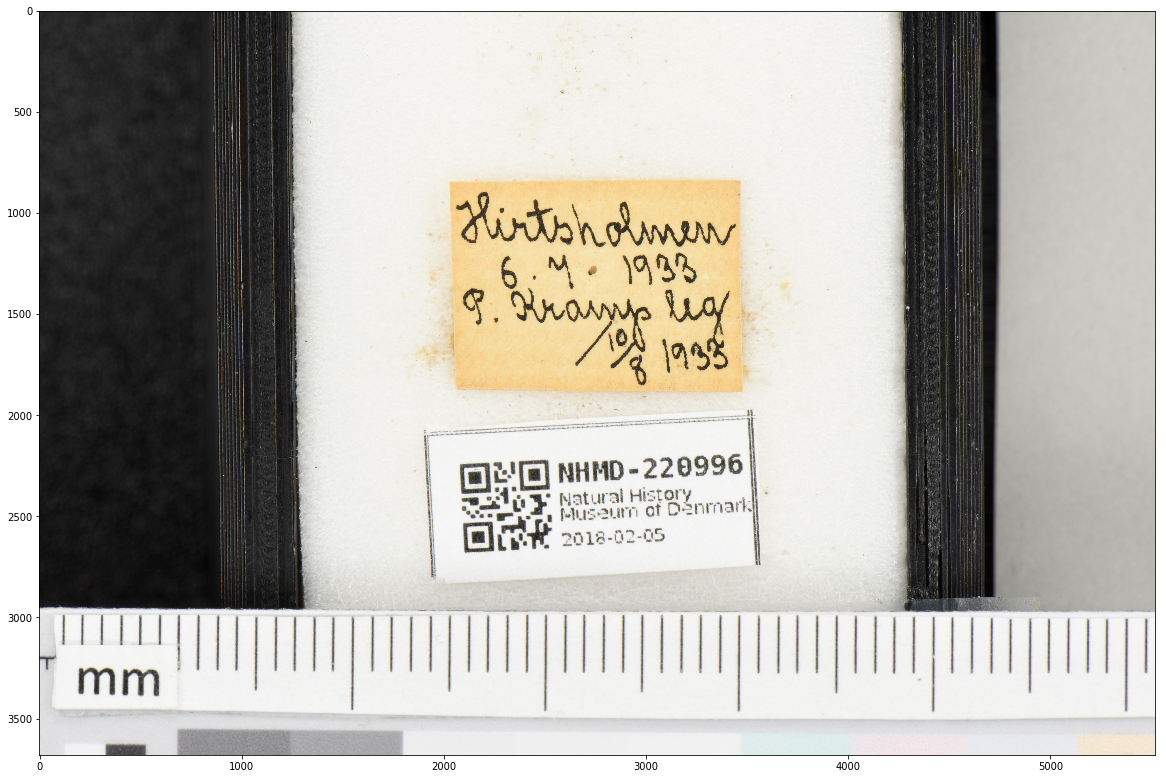

In [2]:
fp = '/home/rob/HWR/datasets/zooniverse/220996/Preview002.jpg'

raw = cv2.imread(fp)
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(raw, cv2.COLOR_BGR2RGB))
#a = detect_text(fp, show_image=True)

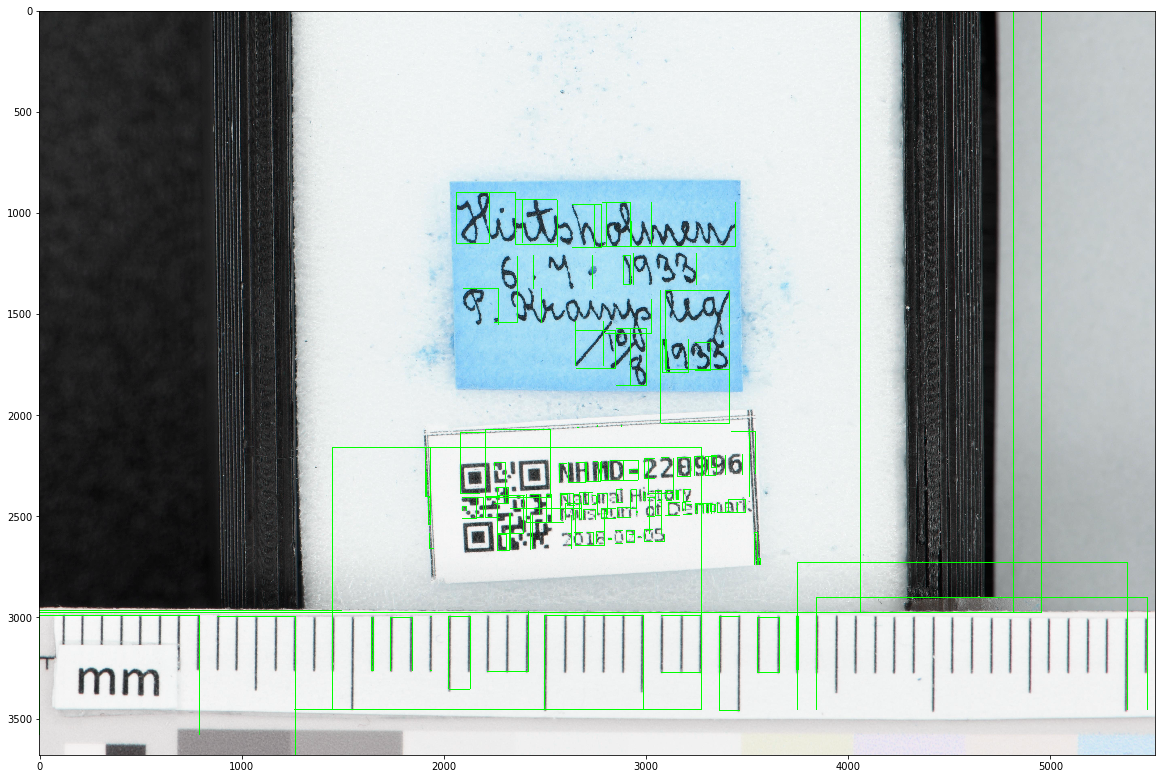

In [4]:
import pytesseract
img = raw
h, w, _ = img.shape # assumes color image

# run tesseract, returning the bounding boxes
boxes = pytesseract.image_to_boxes(img) # also include any config options you use

# draw the bounding boxes on the image
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# show annotated image and wait for keypress
plt.figure(figsize=(20,20))
plt.imshow(img)


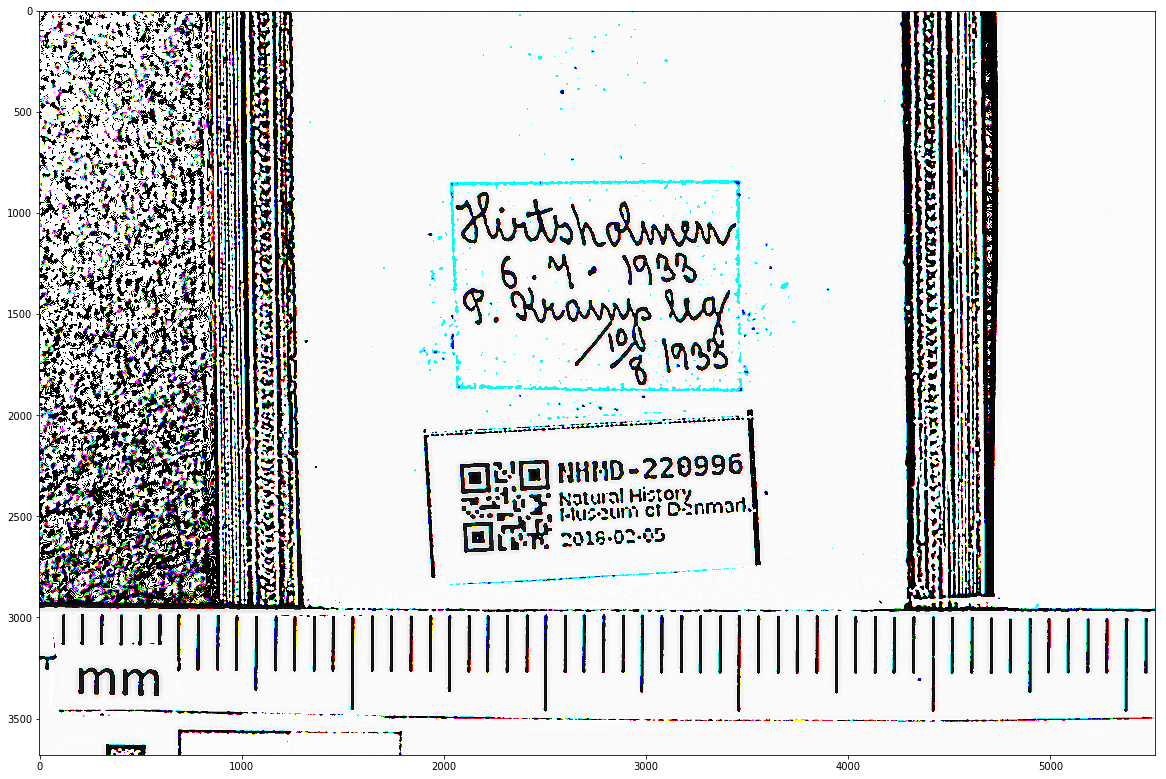

In [63]:
gaus = cv2.GaussianBlur(raw, (91,91), 10)
gaus2 = cv2.GaussianBlur(raw, (61,61), 6)
plt.figure(figsize=(20,20))
plt.imshow(gaus - gaus2)

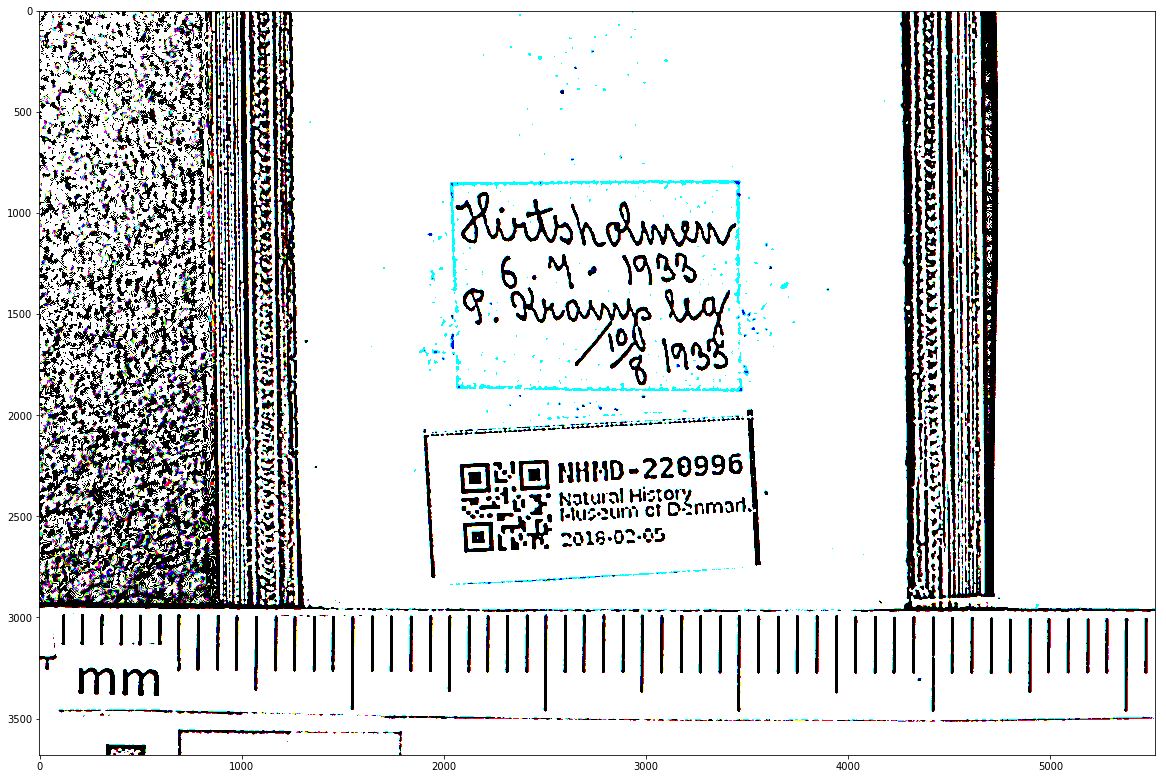

In [70]:

d = gaus - gaus2
ret,d = cv2.threshold(d,160,255,cv2.THRESH_BINARY)
plt.figure(figsize=(20,20))
plt.imshow(d)

[INFO] loading EAST text detector...
[INFO] text detection took 4.211867 seconds


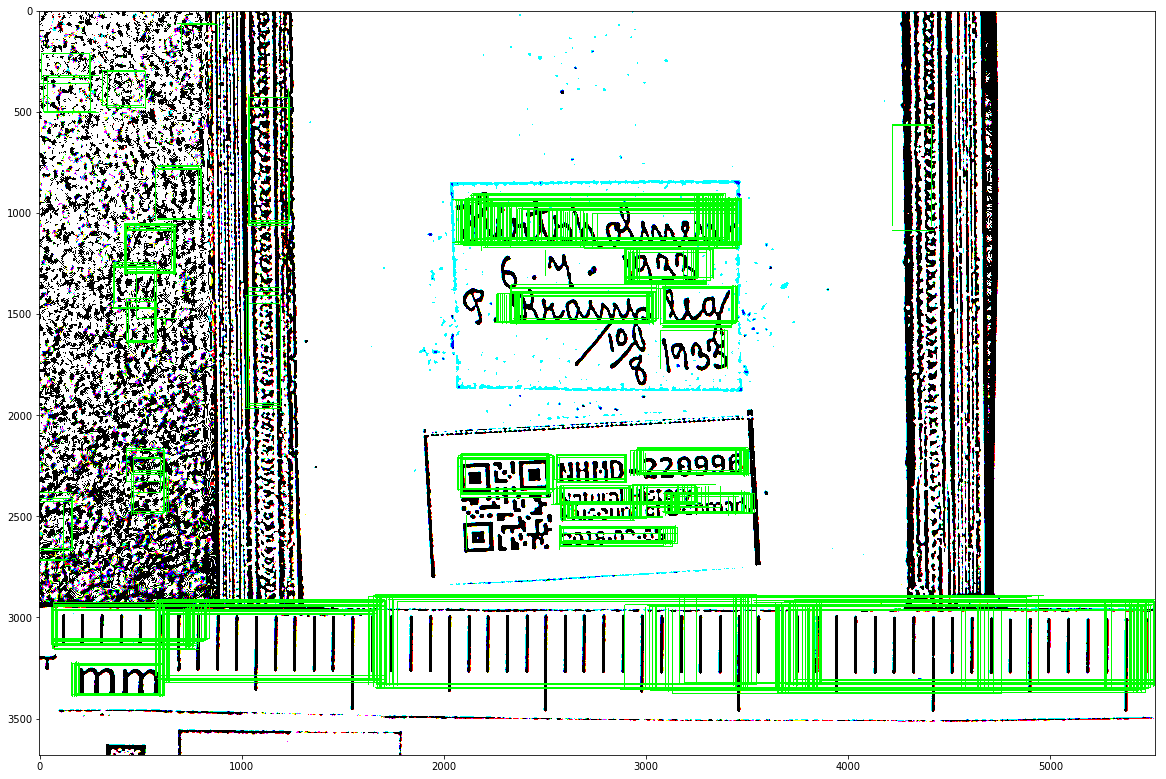

In [51]:
detect_text(d, show_image=True);

In [ ]:
 
a, cnt, h = cv2.findContours(cv2.cvtColor(d, cv2.COLOR_BGR2GRAY),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(cnt)):
    area = cv2.contourArea(cnt[i])
    if(area>50000 ):
        mask = np.zeros_like(d)
        cv2.drawContours(mask, cnt, i, 255, -1)
        x,y,w,h = cv2.boundingRect(cnt[i])
        crop= d[ y:h+y,x:w+x]
        plt.figure(figsize=(20,20))
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB) )


In [59]:
.shape

(3680, 5520, 1)

In [4]:
def detect_text(img, show_image = False):
    # load the input image and grab the image dimensions
    image = img
    orig = image.copy()
    (H, W) = image.shape[:2]
    (H/32,W/32)

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (11*32*4, 7*32*4)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]    

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet('frozen_east_text_detection.pb')

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]


        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.8:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    
    if show_image == True:
        # loop over the bounding boxes
        for (startX, startY, endX, endY) in rects:
            # scale the bounding box coordinates based on the respective
            # ratios
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            # draw the bounding box on the image
            cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # show the output image
        plt.figure(figsize=(20,20))
        plt.imshow(orig)
        cv2.waitKey(0)
    
    return rects, confidences

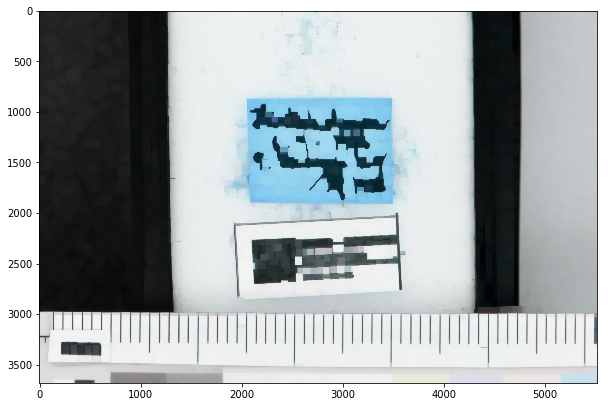

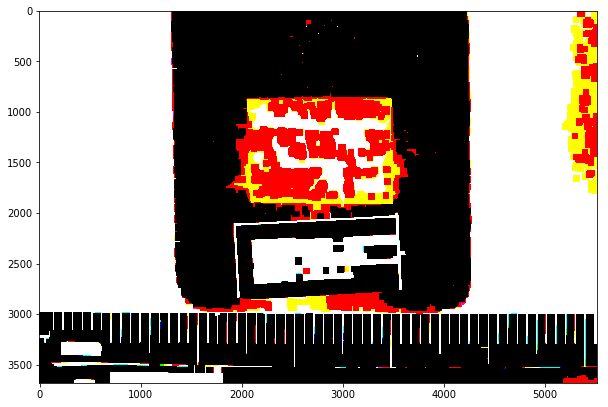

In [24]:

h, w = raw.shape[:2]
kernel = np.ones((30,30),np.uint8)

e = cv2.erode(raw,kernel,iterations = 2)  
d = cv2.dilate(e,kernel,iterations = 2)
for i in range(10):
    e = cv2.erode(d,kernel,iterations = 2)  
    d = cv2.dilate(e,kernel,iterations = 2)
ret, th = cv2.threshold(d, 200, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10,10))
plt.imshow(d)
plt.figure(figsize=(10,10))
plt.imshow(th)

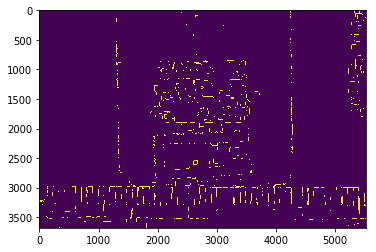

In [26]:
gray = cv2.cvtColor(th, cv2.COLOR_BGR2GRAY)
dog = cv2.GaussianBlur(gray, (151,151), 2.5) - cv2.GaussianBlur(gray, (151,151), 1)
can = cv2.Canny(dog, 5, 50, 200)
plt.imshow(can)

In [61]:


mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(cdst, mask, (200,200), 255); # position = (200,200)
out = cv2.bitwise_not(cdst)
out= cv2.dilate(out,kernel,iterations = 3)
a, cnt, h = cv2.findContours(out,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(cnt)):
    area = cv2.contourArea(cnt[i])
    if(area>10000 and area<100000):
        mask = np.zeros_like(img)
        cv2.drawContours(mask, cnt, i, 255, -1)
        x,y,w,h = cv2.boundingRect(cnt[i])
        crop= img[ y:h+y,x:w+x]
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB) )
        if(cv2.waitKey(0))==27:break

cv2.destroyAllWindows()

error: OpenCV(3.4.3) /io/opencv/modules/imgproc/src/contours.cpp:199: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


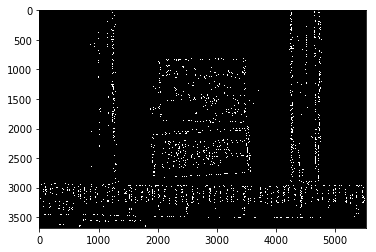

In [40]:
gaus = cv2.GaussianBlur(raw, (101,101), 10)
#laped = cv2.Laplacian(raw, 6)
cdst = cv2.Canny(gaus, 5, 10, 100)
plt.imshow(cdst, cmap='gray')

In [26]:
cv2.Canny?

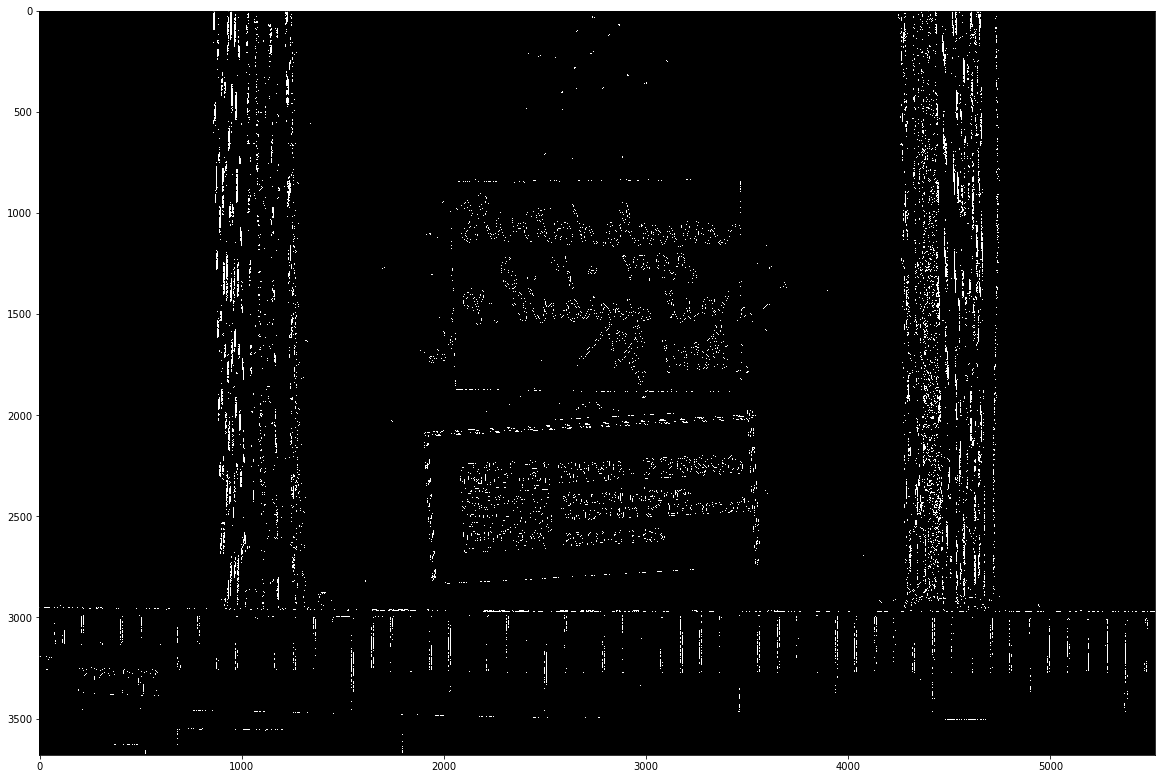

In [56]:
src = cv2.imread(fp)
dst = cv2.GaussianBlur(src,(15,15),2)
cdst = cv2.Canny(dst, 10, 50)
cdst = cv2.cvtColor(cdst, cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(20,20))
plt.imshow(cdst, cmap='gray')

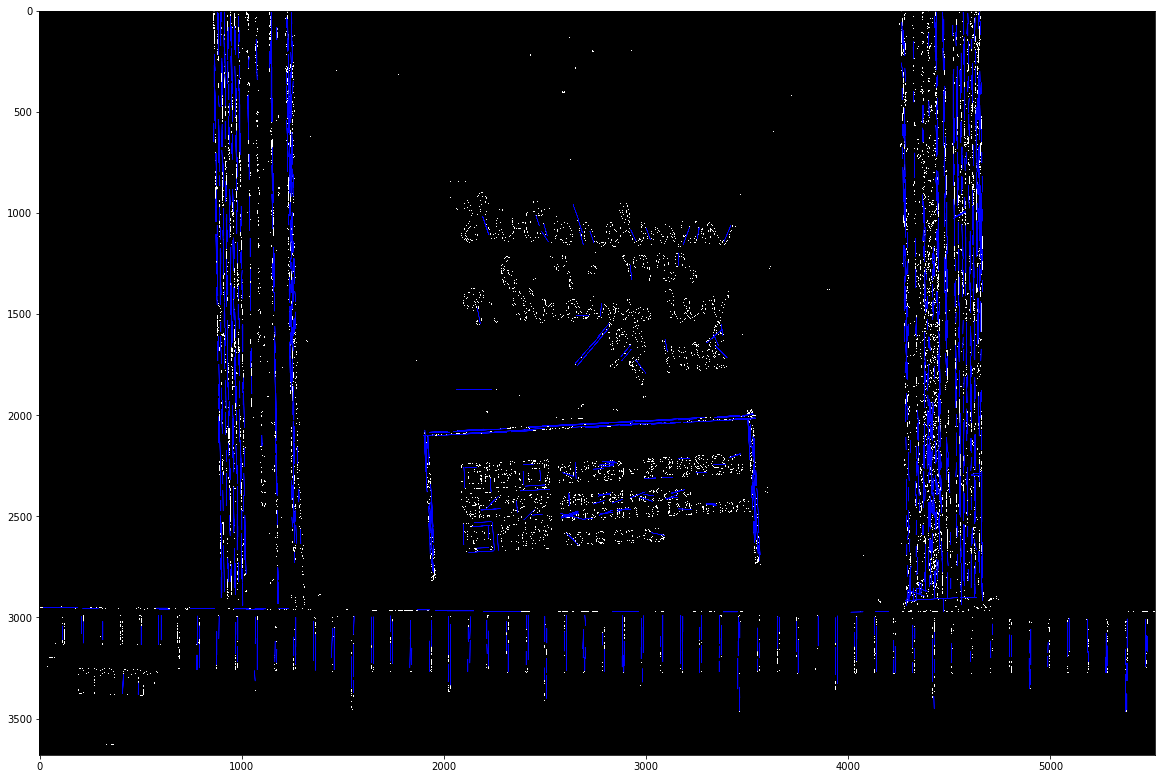

In [42]:
lines = cv2.HoughLinesP(dst, 1, math.pi/180.0, 40, np.array([]), 50, 10)

a,b,c = lines.shape
for i in range(a):
    cv2.line(cdst, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv2.LINE_AA)
plt.figure(figsize=(20,20))
plt.imshow(cdst, cmap='gray')

In [28]:
cv2.CV_64F

6

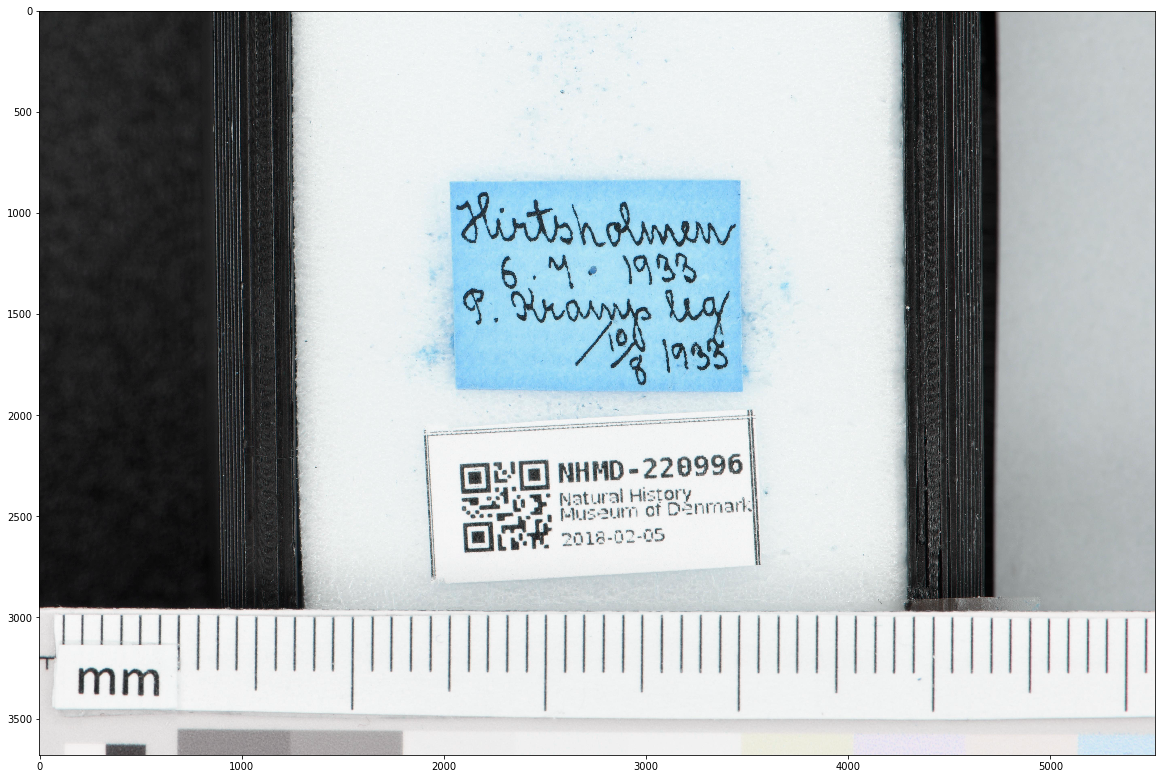

In [35]:
src = cv2.imread(fp)
#src = cv2.GaussianBlur(src, (151,151), 1.5)
#src = cv2.Laplacian(src, 6)
dst = cv2.Canny(src, 50, 200)
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(20,20))
plt.imshow(src, cmap='gray')

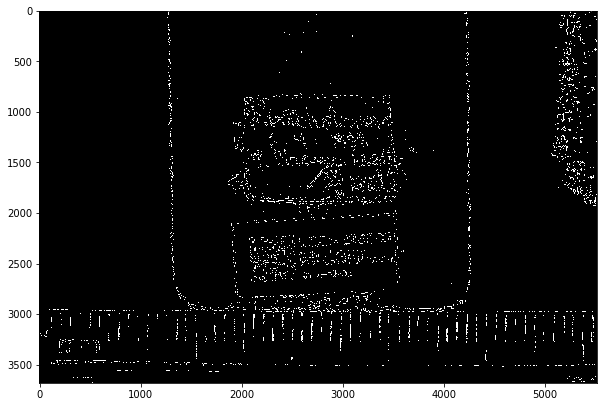

In [47]:
dog = cv2.GaussianBlur(th,(151,151),2) - cv2.GaussianBlur(th,(151,151),1)
#cdst = cv2.cvtColor(dog, cv2.COLOR_GRAY2BGR)
dst = cv2.Canny(dog, 50, 200)
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(cdst, cmap='gray')

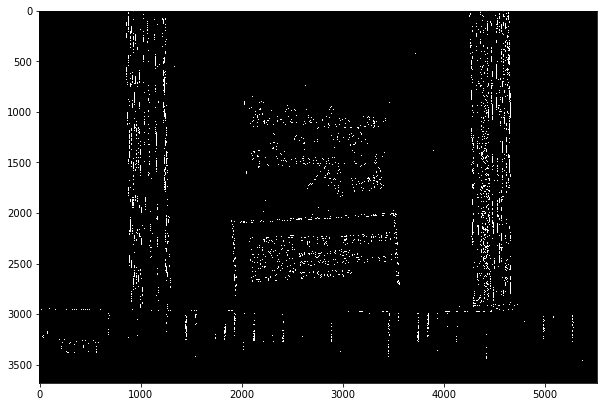

In [38]:
#img = '/home/rob/NHMA-ENT-199441-lab.jpg'
src = cv2.imread(fp)
dog = cv2.GaussianBlur(src,(151,151),2) - cv2.GaussianBlur(src,(151,151),1)
dst = cv2.Canny(src, 50, 200)
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(cdst, cmap='gray')

In [ ]:
a = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
lines = cv2.HoughLines(a, 1, math.pi/180.0, 150, np.array([]), 10, 10)
if lines is not None:
    a,b,c = lines.shape
    for i in range(a):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0, y0 = a*rho, b*rho
        pt1 = ( int(x0+1000*(-b)), int(y0+1000*(a)) )
        pt2 = ( int(x0-1000*(-b)), int(y0-1000*(a)) )
        cv2.line(cdst, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
plt.figure(figsize=(10,10))
plt.imshow(cdst, cmap='gray')

In [ ]:
if __name__ == '__main__':
    print(__doc__)

    try:
        fn = sys.argv[1]
    except IndexError:
        fn = "../data/pic1.png"

    src = cv.imread(fn)
    dst = cv.Canny(src, 50, 200)
    cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)

    if True: # HoughLinesP
        lines = cv.HoughLinesP(dst, 1, math.pi/180.0, 40, np.array([]), 50, 10)
        a,b,c = lines.shape
        for i in range(a):
            cv.line(cdst, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv.LINE_AA)

    else:    # HoughLines
        lines = cv.HoughLines(dst, 1, math.pi/180.0, 50, np.array([]), 0, 0)
        if lines is not None:
            a,b,c = lines.shape
            for i in range(a):
                rho = lines[i][0][0]
                theta = lines[i][0][1]
                a = math.cos(theta)
                b = math.sin(theta)
                x0, y0 = a*rho, b*rho
                pt1 = ( int(x0+1000*(-b)), int(y0+1000*(a)) )
                pt2 = ( int(x0-1000*(-b)), int(y0-1000*(a)) )
                cv.line(cdst, pt1, pt2, (0, 0, 255), 3, cv.LINE_AA)

    cv.imshow("detected lines", cdst)

    cv.imshow("source", src)
cv.waitKey(0)